In [580]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import operator
from math import floor,ceil
import tensorflow as tf
print(tf.__version__)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pytesseract

2.1.0


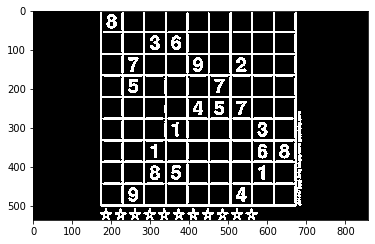

In [32]:
def proc_img(img):
    img1 = cv.GaussianBlur(img.copy(), (9, 9), 0)
    img1 = cv.adaptiveThreshold(img1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    img1 = cv.bitwise_not(img1, img1)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    img1 = cv.dilate(img1, kernel)
    return img1

img = cv.imread('sudoku2.jpg', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
plt.imshow(processed,'gray')

In [33]:
def show_img(img):
	cv.imshow('image', img)
	cv.waitKey(0)
	cv.destroyAllWindows()

In [34]:
def display_points(img, points, radius=5, colour=(0, 0, 255)):
    img = img.copy()
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    for point in points:
        img = cv.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    show_img(img)

In [35]:
def grid(img):
    contours, _ = cv.findContours(img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    cnt = contours[0]
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    return [cnt[top_left][0], cnt[top_right][0], cnt[bottom_right][0], cnt[bottom_left][0]]

img = cv.imread('sudoku1.png', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
print(corners)
display_points(processed, corners)

[array([ 46, 143], dtype=int32), array([381, 146], dtype=int32), array([380, 478], dtype=int32), array([ 44, 478], dtype=int32)]


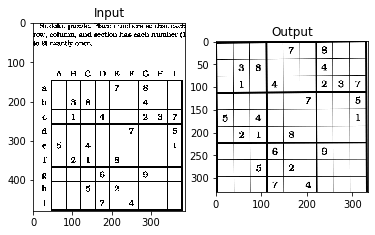

In [143]:
def perspect(img,corners):
    rows,cols = img.shape
    h = corners[1][0] - corners[0][0]
    w = corners[2][1] - corners[1][1]
    pts1 = np.float32([corners[0],corners[1],corners[3],corners[2]])
    #pts1 = np.float32([[x,y],[x+w,y],[x,y+h],[x+w,y+h]])
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    M = cv.getPerspectiveTransform(pts1,pts2)
    dst = cv.warpPerspective(img,M,(h,w))
    show_img(dst)
    plt.subplot(121),plt.imshow(img,'gray'),plt.title('Input')
    plt.subplot(122),plt.imshow(dst,'gray'),plt.title('Output')
    return dst

img = cv.imread('sudoku1.png', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
img_final = perspect(img,corners)

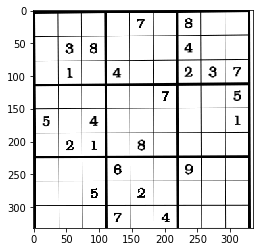

In [144]:
plt.imshow(img_final,'gray')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fead0711320>,
 Text(0.5, 1.0, 'Output'))

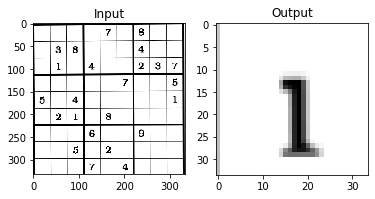

In [147]:
rowp = row/9
colp = col/9
i=1
j=2
pts1 = np.float32([[i*1.05*rowp,j*(1.05*colp)],[(i+1)*0.95*rowp,j*1.05*colp],[i*1.05*rowp,(j+1)*0.95*colp],[(i+1)*0.95*rowp,(j+1)*0.95*colp]])
#pts1 = np.float32([[x,y],[x+w,y],[x,y+h],[x+w,y+h]])
pts2 = np.float32([[0,0],[0.9*rowp,0],[0,0.9*colp],[0.9*rowp,0.9*colp]])
M = cv.getPerspectiveTransform(pts1,pts2)
dst = cv.warpPerspective(img_final,M,(ceil(0.9*rowp),ceil(0.9*colp)))
plt.subplot(121),plt.imshow(img_final,'gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst,'gray'),plt.title('Output')

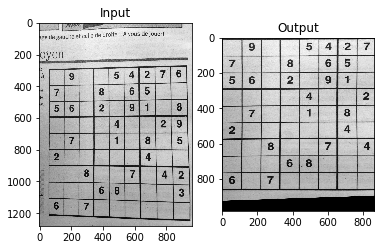

In [636]:
def extract_grid(img):
    row, col = img.shape
    rowp = row/9
    colp = col/9
    imgp = []
    dim = (floor(rowp),floor(colp))
    for i in range(9):
        for j in range(9):
            pts1 = np.float32([[i*1.025*rowp,j*1.025*colp],[(i+1)*0.975*rowp,j*1.025*colp],[i*1.025*rowp,(j+1)*0.975*colp],[(i+1)*0.975*rowp,(j+1)*0.975*colp]])
            pts2 = np.float32([[0,0],[rowp,0],[0,colp],[rowp,colp]])
            M = cv.getPerspectiveTransform(pts1,pts2)
            dst = cv.warpPerspective(img,M,dim)
            imgp.append(dst)
    return imgp

img = cv.imread('sudoku.jpg', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
img_final = perspect(img,corners)
imgp = extract_grid(img_final)

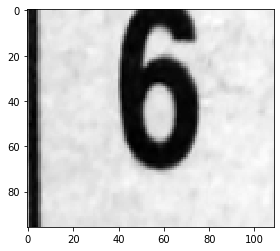

In [638]:
plt.imshow(imgp[8],'gray')

1


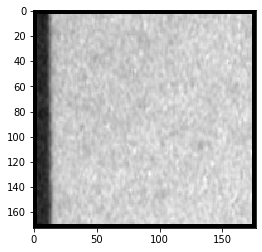

In [612]:
#imgray = cv.cvtColor(imgp[10], cv.COLOR_BGR2GRAY)
#thresh = cv.adaptiveThreshold(imgp[10],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
contours, hierarchy = cv.findContours(imgp[8], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
temp = cv.drawContours(imgp[8].copy(), contours, 0, (0,255,0), 3)
plt.imshow(temp,'gray')
print(len(contours))

In [627]:
def load_ocr_data(path):
    # get a list of all the images
    imlist = [os.path.join(path,f) for f in os.listdir(path)]
    # create labels
    labels = [int(imfile.split('/')[-1][0]) for imfile in imlist]

    # create features from the images
    features = []
    for imname in imlist:
        '''im = array(Image.open(imname).convert('L'))
        features.append(compute_feature(im))'''
        im = cv.imread(imname,cv.IMREAD_GRAYSCALE)
        im = cv.medianBlur(im.copy(), 5)
        #im = cv.adaptiveThreshold(im, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
        #im = cv.bitwise_not(im, im)
        features.append(im)
    return features,labels

In [628]:
features,labels = load_ocr_data('ocr_data/training/')
features = np.asarray(features)
labels = np.asarray(labels)
print(labels)

[3 6 0 ... 9 9 9]


In [629]:
print(features[0].shape)
print(features[1])
x_train = []
for f in features:
    resized = cv.resize(f, (80,80), interpolation = cv.INTER_AREA) 
    x_train.append(resized)
    

x_train = np.asarray(x_train)

x_train = x_train.reshape(x_train.shape[0], 80, 80, 1)

#features = features.reshape(1409, 80, 80, 1)
#x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
#print(x_train[1].shape)
#input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
#x_test /= 255

(80, 80)
[[ 75  89  99 ...  75  71  59]
 [ 89  97 100 ...  89  75  71]
 [113 117 131 ... 110  95  92]
 ...
 [100 105 110 ...  93  87  76]
 [ 95 100 105 ...  87  76  74]
 [ 88  95 104 ...  80  74  70]]


In [630]:
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=(80,80,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [634]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=labels, epochs=5)

Epoch 1/5
2139/2139 [==============================] - 5s 3ms/step - loss: 0.5978 - accuracy: 0.7784
Epoch 2/5
2139/2139 [==============================] - 5s 3ms/step - loss: 0.5886 - accuracy: 0.7784
Epoch 3/5
2139/2139 [==============================] - 5s 2ms/step - loss: 0.5505 - accuracy: 0.7957
Epoch 4/5
2139/2139 [==============================] - 5s 2ms/step - loss: 0.5382 - accuracy: 0.7924
Epoch 5/5
2139/2139 [==============================] - 5s 3ms/step - loss: 0.5244 - accuracy: 0.8027


(80, 80)
[[4.5018700e-05 4.0998403e-02 3.2646775e-03 8.7639377e-02 2.0224579e-02
  1.5801764e-01 1.9458935e-01 1.2591147e-04 1.3581605e-01 3.5927898e-01]]
9


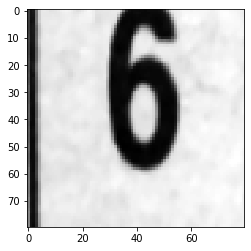

In [639]:
temp = np.asarray(imgp)
#print(temp[3].shape)
temp1 = cv.medianBlur(temp[8].copy(), 3)
#temp1 = cv.adaptiveThreshold(temp1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
#temp1 = cv.bitwise_not(temp1, temp1)
temp1 = cv.resize(temp1, (80,80), interpolation = cv.INTER_AREA) 
plt.imshow(temp1,'gray')
print(temp1.shape)
temp1 = temp1.reshape(1,80,80, 1)
temp1 = temp1.astype('float32')
temp1 /= 255
predict = model.predict(temp1)
print(predict)
print(np.argmax(predict))
#temp2 = cv.cvtColor(temp[5],cv.COLOR_GRAY2RGB)
#pred = pytesseract.image_to_string(temp2, lang='eng',config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
#print(pred)

In [600]:
features_test,labels_test = load_ocr_data('ocr_data/testing/')
features_test = np.asarray(features_test)
labels_test = np.asarray(labels_test)
print(labels_test)
print(features_test[0].shape)
print(features_test[1])
x_test = []
for f in features_test:
    resized = cv.resize(f, (80,80), interpolation = cv.INTER_AREA) 
    x_test.append(resized)

x_test = np.asarray(x_test)

x_test = x_test.reshape(x_test.shape[0], 80, 80, 1)
x_test = x_test.astype('float32')
x_test /= 255

ValueError: invalid literal for int() with base 10: 's'

In [599]:
model.evaluate(x_test, labels_test, verbose=1)

997/997 [==============================] - 1s 770us/step


[0.09402610232935399, 0.9789367914199829]